In [0]:
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

In [2]:
transforms = transforms.Compose([transforms.Resize(255),transforms.ToTensor(),
                                 transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

trainset = datasets.CIFAR10(root='/data', transform=transforms, train=True, download=True)
testset = datasets.CIFAR10(root='/data', transform=transforms, train=False)
valset, testset = torch.utils.data.random_split(testset, [int(0.9 * len(testset)), int(0.1 * len(testset))])


trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=32, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

print("Training dataset size: ", len(trainset))
print("Validation dataset size: ", len(valset))
print("Testing dataset size: ", len(testset))


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Training dataset size:  50000
Validation dataset size:  9000
Testing dataset size:  1000


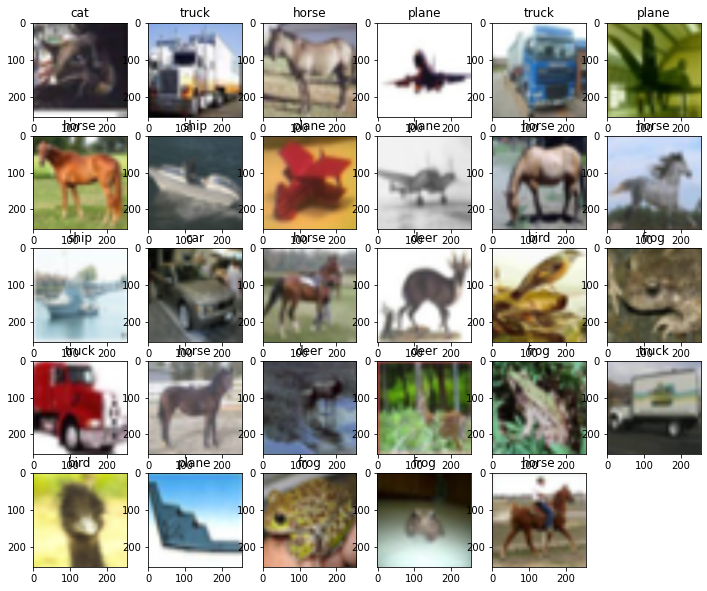

In [3]:
def imshow(img):
    img = img*0.5 + 0.5     
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(trainloader)
images, labels = dataiter.next()

fig=plt.figure(figsize=(12, 10))
for i in range(1,30):
    fig.add_subplot(5,6,i)
    plt.title(classes[labels[i]])
    imshow(images[i])
plt.show()


In [0]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 96, 11, 4),
            nn.ReLU(True),            
            nn.BatchNorm2d(96),
            nn.MaxPool2d(3,2),

            nn.Conv2d(96, 256, 5, padding=2),
            nn.ReLU(True),            
            nn.BatchNorm2d(256),
            nn.MaxPool2d(3,2),

            nn.Conv2d(256, 384, 3, padding=1),
            nn.ReLU(True),            
            nn.Conv2d(384, 384, 3, padding=1),
            nn.ReLU(True),            
            nn.Conv2d(384, 256, 3, padding=1),
            nn.ReLU(True),            
            nn.MaxPool2d(3,2),
            nn.Flatten(),

            nn.Linear(256*6*6, 4096),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.Dropout(0.5),
            nn.Linear(4096,10))

    def forward(self, x):
        return self.main(x)


In [5]:
net = AlexNet()
net

AlexNet(
  (main): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU(inplace=True)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten()
    (1

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

if (torch.cuda.is_available()):
    net.cuda()

In [7]:
# Train on a single mini batch
no_epochs = 201
net.train()

image, label = next(iter(trainloader))
image = image.cuda()
label = label.cuda()
total = 0

for epoch in range(no_epochs):   

        optimizer.zero_grad()
        pred = net(image)
        loss = criterion(pred, label)

        loss.backward()
        optimizer.step()
         
        if epoch % 10 == 0:
            print("Epoch {}: Loss: {}".format(epoch+1, loss.item()))
        

Epoch 1: Loss: 2.311790704727173
Epoch 11: Loss: 2.244730234146118
Epoch 21: Loss: 2.121616840362549
Epoch 31: Loss: 1.965354323387146
Epoch 41: Loss: 1.8394737243652344
Epoch 51: Loss: 1.5370783805847168
Epoch 61: Loss: 1.0432145595550537
Epoch 71: Loss: 0.5211080312728882
Epoch 81: Loss: 0.2745338976383209
Epoch 91: Loss: 0.09182171523571014
Epoch 101: Loss: 0.0688047707080841
Epoch 111: Loss: 0.024689793586730957
Epoch 121: Loss: 0.0101432204246521
Epoch 131: Loss: 0.010184794664382935
Epoch 141: Loss: 0.01439201831817627
Epoch 151: Loss: 0.003671124577522278
Epoch 161: Loss: 0.0036358684301376343
Epoch 171: Loss: 0.0035185813903808594
Epoch 181: Loss: 0.004255950450897217
Epoch 191: Loss: 0.0036221742630004883
Epoch 201: Loss: 0.0036989450454711914


In [14]:
no_epochs = 200
train_loss = list()
val_loss = list()
best_val_loss = 1

for epoch in range(no_epochs):
    total_train_loss = 0
    total_val_loss = 0

    net.train()
    # training
    for iteration, (image, label) in enumerate(trainloader):

        if (torch.cuda.is_available()):
            image = image.cuda()
            label = label.cuda()

        optimizer.zero_grad()

        pred = net(image)

        loss = criterion(pred, label)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    total_train_loss = total_train_loss / (iteration + 1)
    train_loss.append(total_train_loss)

    # validation
    net.eval()
    total = 0
    for iteration, (image, label) in enumerate(valloader):

        if (torch.cuda.is_available()):
            image = image.cuda()
            label = label.cuda()

        pred = net(image)

        loss = criterion(pred, label)
        total_val_loss += loss.item()

        pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1

    accuracy = total / len(valset)

    total_val_loss = total_val_loss / (iteration + 1)
    val_loss.append(total_val_loss)

    print('\nEpoch: {}/{}, Train Loss: {:.8f}, Val Loss: {:.8f}, Val Accuracy: {:.8f}'.format(epoch + 1, no_epochs, total_train_loss, total_val_loss, accuracy))

    if total_val_loss < best_val_loss:
        best_val_loss = total_val_loss
        print("Saving the model state dictionary for Epoch: {} with Validation loss: {:.8f}".format(epoch + 1, total_val_loss))
        torch.save(net.state_dict(), "net.dth")


Epoch: 1/200, Train Loss: 0.16114563, Val Loss: 0.65359098, Val Accuracy: 0.81733333
Saving the model state dictionary for Epoch: 1 with Validation loss: 0.65359098


KeyboardInterrupt: ignored

In [0]:
# Saving and loading the model
path = 'drive/My Drive/Colab/net.dth'

def save():
    # from google.colab import drive
    # drive.mount('/content/gdrive')
    torch.save(net.state_dict(), path)

def load():
    net.load_state_dict(torch.load(path))

In [0]:
load()

GroundTruth:   ship  frog truck truck   cat  frog  ship  frog   dog plane   cat  deer  deer  ship truck  frog
Predicted:   ship   dog truck truck   cat  frog  ship  frog   cat plane   cat  deer  deer  ship truck  frog


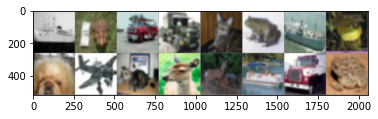

In [16]:
# Testing the model on a few images
net.cpu()
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images[:16]))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(16)))

output = net(images)

_, predicted = torch.max(output, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(16)))

In [23]:
# Over the entire data set
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: {}'.format(100 * correct / total))

Accuracy of the network on the 10000 test images: 82.4


In [24]:
# Which classes performed better
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of {} : {}'.format(classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 92.3076923076923
Accuracy of car : 91.66666666666667
Accuracy of bird : 85.71428571428571
Accuracy of cat : 73.91304347826087
Accuracy of deer : 100.0
Accuracy of dog : 66.66666666666667
Accuracy of frog : 54.54545454545455
Accuracy of horse : 92.85714285714286
Accuracy of ship : 100.0
Accuracy of truck : 100.0
